<a href="https://colab.research.google.com/github/WoogiWooks/Repeat_Paper/blob/main/ResNet_%EA%B0%9C%EB%85%90%20%EB%B0%8F%20%EA%B5%AC%ED%98%84.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

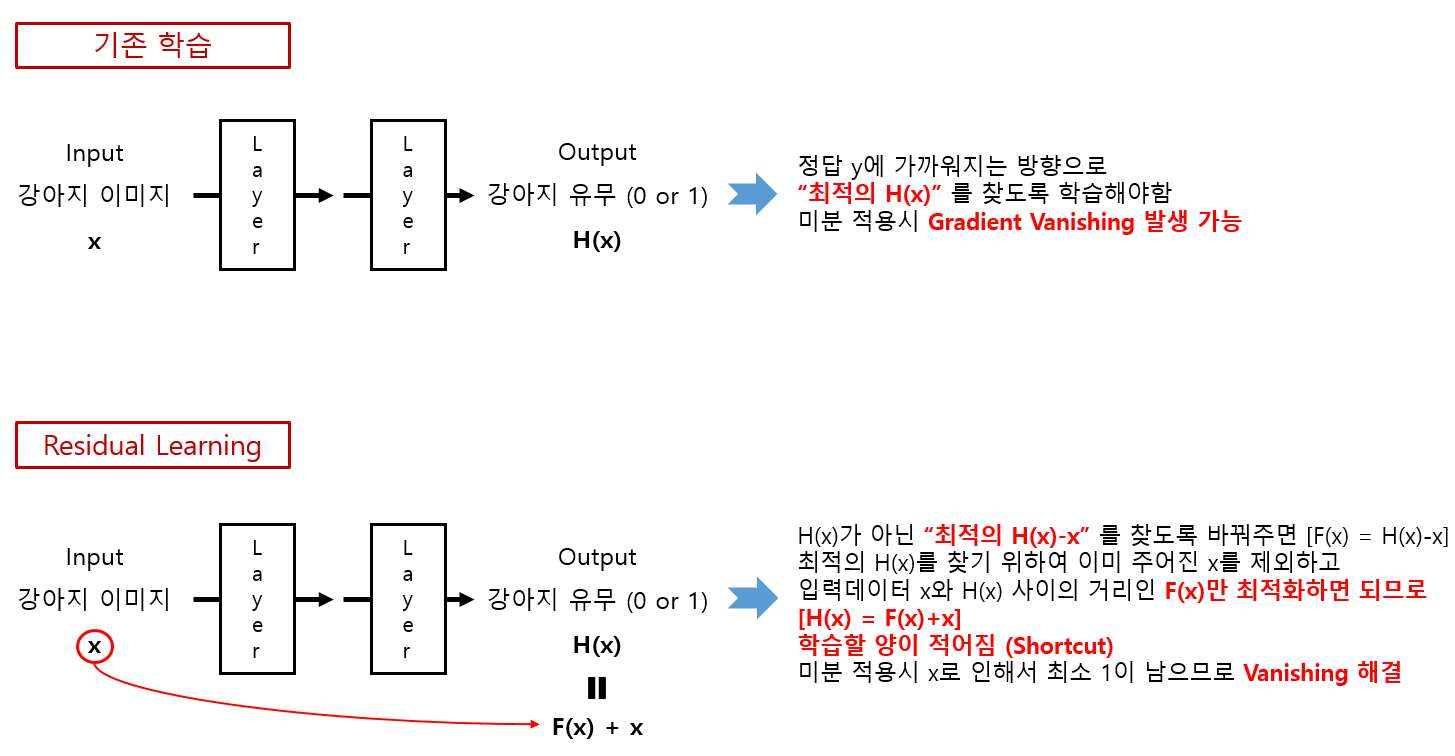

In [ ]:
import torch
import torch.nn as nn
import torch.optim as optim
import torchvision
from torchvision import transforms as tr
import torch.optim as optim
import torch.nn.functional as F
from torch.utils.data import DataLoader
from PIL import Image
import torchvision.models as models
import matplotlib.pyplot as plt
import numpy as np
from tqdm import tqdm

In [ ]:
device = torch.device("cuda:0")

In [ ]:
# Residual Block 구축
# Residual Block 하나를 거칠 때마다 이미지 사이즈가 줄어들고 채널 수는 늘어남

class ResidualBlock(nn.Module):
  def __init__(self, in_channels, out_channels, stride=1):
    super(ResidualBlock, self).__init__()
    self.in_channels = in_channels
    self.out_channels = out_channels
    self.stride = stride

    self.conv_block = nn.Sequential(
        nn.Conv2d(self.in_channels, self.out_channels, kernel_size=3, stride=stride, padding=1, bias=False), nn.BatchNorm2d(self.out_channels), nn.ReLU(),  # 공식에 의해 사이즈 유지됨,
        nn.Conv2d(self.out_channels, self.out_channels, kernel_size=3, stride=1, padding=1, bias=False), nn.BatchNorm2d(self.out_channels) # 공식에 의해 사이즈 유지됨,   # x+F(x) 가능,  # 합친 뒤 ReLU()
            )
    if self.stride != 1 or self.in_channels != self.out_channels :
      self.downsample = nn.Sequential(
          nn.Conv2d(self.in_channels, self.out_channels, kernel_size=1, stride=stride, bias=False), nn.BatchNorm2d(self.out_channels)
      )
    
  def forward(self, x):
    out = self.conv_block(x)
    # 사이즈 조정이 필요할 경우 입력값 크기 조정
    if self.stride != 1 or self.in_channels != self.out_channels :
      x = self.downsample(x)
    out = F.relu(x + out)
    return out

In [ ]:
# ResNet18 모델 구축

class ResNet(nn.Module):
  def __init__(self, num_blocks, num_classes=10):
    super(ResNet, self).__init__()
    self.in_channels = 64
    self.base = nn.Sequential(
        nn.Conv2d(3, 64, kernel_size=3, stride=1, padding=1, bias=False), nn.BatchNorm2d(64), nn.ReLU()   # 공식에 의해 Input Size 와 Output Size 같게 만들어짐
    )
    self.layer1 = self.make_layer(64, num_blocks[0], stride=1)  # Block 2개 만들어 짐
    self.layer2 = self.make_layer(128, num_blocks[1], stride=2)
    self.layer3 = self.make_layer(256, num_blocks[2], stride=2)
    self.layer4 = self.make_layer(512, num_blocks[3], stride=2)
    self.gap = nn.AvgPool2d(4)  # 4x4에서 평균 뽑아내기
    self.fc = nn.Linear(512, num_classes)

  def make_layer(self, out_channels, num_blocks, stride):
    strides = [stride] + [1]*(num_blocks-1)      # stride => Down-Sampling 진행   # 1 => 사이즈 유지 진행
    layers = []
    for stride in strides:
      block = ResidualBlock(self.in_channels, out_channels, stride)
      layers.append(block)
      self.in_channels = out_channels
    return nn.Sequential(*layers) 

  def forward(self, x):
    out = self.base(x)
    out = self.layer1(out)
    out = self.layer2(out)
    out = self.layer3(out)
    out = self.layer4(out)
    out = self.gap(out)   # (512, 1, 1)
    out = out.view(out.size(0), -1)
    out = self.fc(out)
    return out
  
  

In [ ]:
# make_layer의 strides = [stride] + [1]*(num_blocks-1) 확인
[2]+[1]*2

[2, 1, 1]

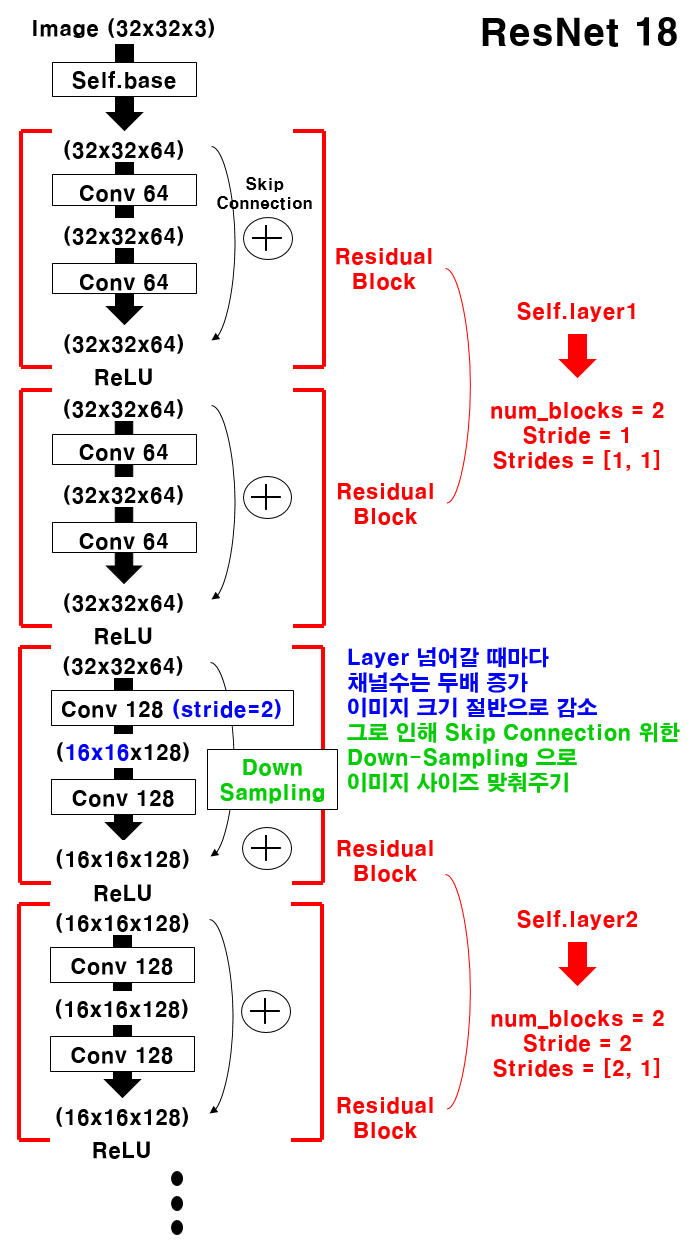

In [ ]:
# 클래스를 불러오는 함수

def modeltype(model):
  if model == "resnet18":
    return ResNet([2, 2, 2, 2])  # num_blocks
  elif model == "resnet34":
    return ResNet([3, 4, 6, 3])

In [ ]:
resnet = modeltype("resnet18").to(device)
resnet

ResNet(
  (base): Sequential(
    (0): Conv2d(3, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
    (1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU()
  )
  (layer1): Sequential(
    (0): ResidualBlock(
      (conv_block): Sequential(
        (0): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
        (1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (2): ReLU()
        (3): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
        (4): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      )
    )
    (1): ResidualBlock(
      (conv_block): Sequential(
        (0): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
        (1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (2): ReLU()
        (3): Conv2d(64, 64, kerne

In [ ]:
# CIFAR10 적용해보기
# 학습은 X
transform = tr.Compose([tr.ToTensor()])
trainset = torchvision.datasets.CIFAR10(root="./", train=True, download=True, transform=transform)
trainloader = DataLoader(trainset, batch_size=32, shuffle=False)

for data in trainloader:
  inputs = data[0].to(device)
  outputs = resnet(inputs)
  _, predicted = torch.max(outputs.detach(), 1)
  print(predicted)
  print(outputs.shape)
  break

  0%|          | 0/170498071 [00:00<?, ?it/s]

Extracting ./cifar-10-python.tar.gz to ./


In [ ]:
# 직관적 모델 구축
# blcokN_1, 2 를 묶어서 생성한게 위에서 만든 모델

class ResNet18(nn.Module):
  def __init__(self):
    super(ResNet18, self).__init__()

    self.base = nn.Sequential(
        nn.Conv2d(3, 64, kernel_size=3, stride=1, padding=1, bias=False), nn.BatchNorm2d(64), nn.ReLU() 
    )

    # Layer 1 (32x32)
    self.block64_1 = nn.Sequential(
        nn.Conv2d(64, 64, kernel_size=3, stride=1, padding=1, bias=False), nn.BatchNorm2d(64), nn.ReLU(),
        nn.Conv2d(64, 64, kernel_size=3, stride=1, padding=1, bias=False), nn.BatchNorm2d(64)
    )

    self.block64_2 = nn.Sequential(
        nn.Conv2d(64, 64, kernel_size=3, stride=1, padding=1, bias=False), nn.BatchNorm2d(64), nn.ReLU(),
        nn.Conv2d(64, 64, kernel_size=3, stride=1, padding=1, bias=False), nn.BatchNorm2d(64)
    )
    
    # Layer 2 (16x16)
    self.block128_1 = nn.Sequential(
        nn.Conv2d(64, 128, kernel_size=3, stride=2, padding=1, bias=False), nn.BatchNorm2d(128), nn.ReLU(),
        nn.Conv2d(128, 128, kernel_size=3, stride=1, padding=1, bias=False), nn.BatchNorm2d(128)
    )

    self.block128_2 = nn.Sequential(
        nn.Conv2d(128, 128, kernel_size=3, stride=1, padding=1, bias=False), nn.BatchNorm2d(128), nn.ReLU(),
        nn.Conv2d(128, 128, kernel_size=3, stride=1, padding=1, bias=False), nn.BatchNorm2d(128)
    )

    # Layer 3 (8x8)
    self.block256_1 = nn.Sequential(
        nn.Conv2d(128, 256, kernel_size=3, stride=2, padding=1, bias=False), nn.BatchNorm2d(256), nn.ReLU(),
        nn.Conv2d(256, 256, kernel_size=3, stride=1, padding=1, bias=False), nn.BatchNorm2d(256)
    )

    self.block256_2 = nn.Sequential(
        nn.Conv2d(256, 256, kernel_size=3, stride=1, padding=1, bias=False), nn.BatchNorm2d(256), nn.ReLU(),
        nn.Conv2d(256, 256, kernel_size=3, stride=1, padding=1, bias=False), nn.BatchNorm2d(256)
    )

    # Layer 4 (4x4)
    self.block512_1 = nn.Sequential(
        nn.Conv2d(256, 512, kernel_size=3, stride=2, padding=1, bias=False), nn.BatchNorm2d(512), nn.ReLU(),
        nn.Conv2d(512, 512, kernel_size=3, stride=1, padding=1, bias=False), nn.BatchNorm2d(512)
    )

    self.block512_2 = nn.Sequential(
        nn.Conv2d(512, 512, kernel_size=3, stride=1, padding=1, bias=False), nn.BatchNorm2d(512), nn.ReLU(),
        nn.Conv2d(512, 512, kernel_size=3, stride=1, padding=1, bias=False), nn.BatchNorm2d(512)
    )

    self.gap = nn.AvgPool2d(4)  # 4x4에서 평균 뽑아내기

    self.fc = nn.Linear(512, 10)

    self.downsampling64_128 = nn.Sequential(
        nn.Conv2d(64, 128, kernel_size=1, stride=2, bias=False), nn.BatchNorm2d(128)
    )

    self.downsampling128_256 = nn.Sequential(
        nn.Conv2d(128, 256, kernel_size=1, stride=2, bias=False), nn.BatchNorm2d(256)
    )

    self.downsampling256_512 = nn.Sequential(
        nn.Conv2d(256, 512, kernel_size=1, stride=2, bias=False), nn.BatchNorm2d(512)
    )


  def forward(self, x):
    out = self.base(x)

    # Layer 1
    out_block64_1 = self.block64_1(out)
    out = F.relu(out + out_block64_1)

    out_block64_2 = self.block64_2(out)
    out = F.relu(out + out_block64_2)

    # Layer 2
    out_block128_1 = self.block128_1(out)
    out = self.downsampling64_128(out)
    out = F.relu(out + out_block128_1)

    out_block128_2 = self.block128_2(out)
    out = F.relu(out + out_block128_2)

    # Layer 3
    out_block256_1 = self.block256_1(out)
    out = self.downsampling128_256(out)
    out = F.relu(out + out_block256_1)

    out_block256_2 = self.block256_2(out)
    out = F.relu(out + out_block256_2)

    # Layer 4
    out_block512_1 = self.block512_1(out)
    out = self.downsampling256_512(out)
    out = F.relu(out + out_block512_1)

    out_block512_2 = self.block512_2(out)
    out = F.relu(out + out_block512_2)

    out = self.gap(out)   # (512, 1, 1)
    out = out.view(out.size(0), -1)
    out = self.fc(out)
    return out
  
  

In [ ]:
# DownSampling 크기 변경 확인
# 이미지 사이즈 변경시 내림 적용 (8.75 -> 8)

class Prac(nn.Module):
  def __init__(self):
    super(Prac, self).__init__()
   
    self.downsample = nn.Sequential(
        nn.Conv2d(64, 128, kernel_size=1, stride=4, bias=False), nn.BatchNorm2d(128)
    )

  def forward(self, x):
    out = self.downsample(x)
    return out.shape
  
noise = torch.randn(1, 64, 32, 32)
noise.shape

prac = Prac()
prac(noise)

torch.Size([1, 128, 8, 8])

In [ ]:
resnet18 = ResNet18().to(device)
resnet18

# init 부분에서 구조 순서를 안맞추니 이상하게 나옴 => 수정필요

ResNet18(
  (base): Sequential(
    (0): Conv2d(3, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
    (1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU()
  )
  (block64_1): Sequential(
    (0): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
    (1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU()
    (3): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
    (4): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (5): ReLU()
  )
  (block64_2): Sequential(
    (0): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
    (1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU()
    (3): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
    (4): BatchNorm2d(64, eps=1e-05, momentum=0.1, af

In [ ]:
# 구동 확인
# 학습은 X

for data in trainloader:
  inputs = data[0].to(device)
  outputs = resnet18(inputs)
  _, predicted = torch.max(outputs.detach(), 1)
  print(predicted)
  print(outputs.shape)
  break

tensor([5, 5, 5, 9, 5, 5, 5, 5, 5, 5, 5, 5, 5, 9, 5, 9, 5, 9, 5, 5, 5, 5, 9, 9,
        9, 9, 5, 5, 5, 5, 9, 5], device='cuda:0')
torch.Size([32, 10])


In [ ]:
# 직관적 모델 구축 - 수정 버전

class ResNet18_modify(nn.Module):
  def __init__(self):
    super(ResNet18_modify, self).__init__()

    self.base = nn.Sequential(
        nn.Conv2d(3, 64, kernel_size=3, stride=1, padding=1, bias=False), nn.BatchNorm2d(64), nn.ReLU() 
    )

    # Layer 1 (32x32)
    self.block64_1 = nn.Sequential(
        nn.Conv2d(64, 64, kernel_size=3, stride=1, padding=1, bias=False), nn.BatchNorm2d(64), nn.ReLU(),
        nn.Conv2d(64, 64, kernel_size=3, stride=1, padding=1, bias=False), nn.BatchNorm2d(64)
    )

    self.block64_2 = nn.Sequential(
        nn.Conv2d(64, 64, kernel_size=3, stride=1, padding=1, bias=False), nn.BatchNorm2d(64), nn.ReLU(),
        nn.Conv2d(64, 64, kernel_size=3, stride=1, padding=1, bias=False), nn.BatchNorm2d(64)
    )
    
    # Layer 2 (16x16)
    self.block128_1 = nn.Sequential(
        nn.Conv2d(64, 128, kernel_size=3, stride=2, padding=1, bias=False), nn.BatchNorm2d(128), nn.ReLU(),
        nn.Conv2d(128, 128, kernel_size=3, stride=1, padding=1, bias=False), nn.BatchNorm2d(128)
    )

    self.downsampling64_128 = nn.Sequential(
        nn.Conv2d(64, 128, kernel_size=1, stride=2, bias=False), nn.BatchNorm2d(128)
    )

    self.block128_2 = nn.Sequential(
        nn.Conv2d(128, 128, kernel_size=3, stride=1, padding=1, bias=False), nn.BatchNorm2d(128), nn.ReLU(),
        nn.Conv2d(128, 128, kernel_size=3, stride=1, padding=1, bias=False), nn.BatchNorm2d(128)
    )

    # Layer 3 (8x8)
    self.block256_1 = nn.Sequential(
        nn.Conv2d(128, 256, kernel_size=3, stride=2, padding=1, bias=False), nn.BatchNorm2d(256), nn.ReLU(),
        nn.Conv2d(256, 256, kernel_size=3, stride=1, padding=1, bias=False), nn.BatchNorm2d(256)
    )

    self.downsampling128_256 = nn.Sequential(
        nn.Conv2d(128, 256, kernel_size=1, stride=2, bias=False), nn.BatchNorm2d(256)
    )

    self.block256_2 = nn.Sequential(
        nn.Conv2d(256, 256, kernel_size=3, stride=1, padding=1, bias=False), nn.BatchNorm2d(256), nn.ReLU(),
        nn.Conv2d(256, 256, kernel_size=3, stride=1, padding=1, bias=False), nn.BatchNorm2d(256)
    )

    # Layer 4 (4x4)
    self.block512_1 = nn.Sequential(
        nn.Conv2d(256, 512, kernel_size=3, stride=2, padding=1, bias=False), nn.BatchNorm2d(512), nn.ReLU(),
        nn.Conv2d(512, 512, kernel_size=3, stride=1, padding=1, bias=False), nn.BatchNorm2d(512)
    )

    self.downsampling256_512 = nn.Sequential(
        nn.Conv2d(256, 512, kernel_size=1, stride=2, bias=False), nn.BatchNorm2d(512)
    )

    self.block512_2 = nn.Sequential(
        nn.Conv2d(512, 512, kernel_size=3, stride=1, padding=1, bias=False), nn.BatchNorm2d(512), nn.ReLU(),
        nn.Conv2d(512, 512, kernel_size=3, stride=1, padding=1, bias=False), nn.BatchNorm2d(512)
    )

    self.gap = nn.AvgPool2d(4)  # 4x4에서 평균 뽑아내기

    self.fc = nn.Linear(512, 10)


  def forward(self, x):
    out = self.base(x)

    # Layer 1
    out_block64_1 = self.block64_1(out)
    out = F.relu(out + out_block64_1)

    out_block64_2 = self.block64_2(out)
    out = F.relu(out + out_block64_2)

    # Layer 2
    out_block128_1 = self.block128_1(out)
    out = self.downsampling64_128(out)
    out = F.relu(out + out_block128_1)

    out_block128_2 = self.block128_2(out)
    out = F.relu(out + out_block128_2)

    # Layer 3
    out_block256_1 = self.block256_1(out)
    out = self.downsampling128_256(out)
    out = F.relu(out + out_block256_1)

    out_block256_2 = self.block256_2(out)
    out = F.relu(out + out_block256_2)

    # Layer 4
    out_block512_1 = self.block512_1(out)
    out = self.downsampling256_512(out)
    out = F.relu(out + out_block512_1)

    out_block512_2 = self.block512_2(out)
    out = F.relu(out + out_block512_2)

    out = self.gap(out)   # (512, 1, 1)
    out = out.view(out.size(0), -1)
    out = self.fc(out)
    return out 
  

In [ ]:
resnet18_md = ResNet18_modify().to(device)
resnet18_md

ResNet18_modify(
  (base): Sequential(
    (0): Conv2d(3, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
    (1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU()
  )
  (block64_1): Sequential(
    (0): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
    (1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU()
    (3): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
    (4): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (5): ReLU()
  )
  (block64_2): Sequential(
    (0): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
    (1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU()
    (3): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
    (4): BatchNorm2d(64, eps=1e-05, momentum=

In [ ]:
# 구동 확인
# 학습은 X

for data in trainloader:
  inputs = data[0].to(device)
  outputs = resnet18_md(inputs)
  _, predicted = torch.max(outputs.detach(), 1)
  print(predicted)
  print(outputs.shape)
  break

tensor([8, 6, 3, 0, 6, 6, 6, 6, 6, 8, 6, 3, 6, 6, 6, 6, 3, 6, 6, 6, 3, 3, 0, 6,
        6, 6, 0, 6, 6, 6, 6, 6], device='cuda:0')
torch.Size([32, 10])
